<a href="https://colab.research.google.com/github/shyakx/BK_PULSE/blob/main/CHURN_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded successfully (as of 12:33 PM CAT, 10/24/2025).

1. Data Overview:
Dataset shape (rows × columns): (200000, 15)
Class distribution (before balancing):
Churn Label
0    159912
1     40088
Name: count, dtype: int64
Class distribution (after balancing):
Churn Label
1    159912
0    159912
Name: count, dtype: int64
Train/test split summary: 255859 train, 63965 test

2. Model Training & Evaluation:
--------------------------------
Model: Logistic Regression
Accuracy: 0.86
Precision: 1.00
Recall: 0.72
F1-score: 0.83
ROC-AUC: 0.87
-------------------------------
Model: Random Forest
Accuracy: 0.85
Precision: 1.00
Recall: 0.71
F1-score: 0.83
ROC-AUC: 0.87
-------------------------------
Model: Gradient Boosting
Accuracy: 0.86
Precision: 1.00
Recall: 0.71
F1-score: 0.83
ROC-AUC: 0.87
-------------------------------


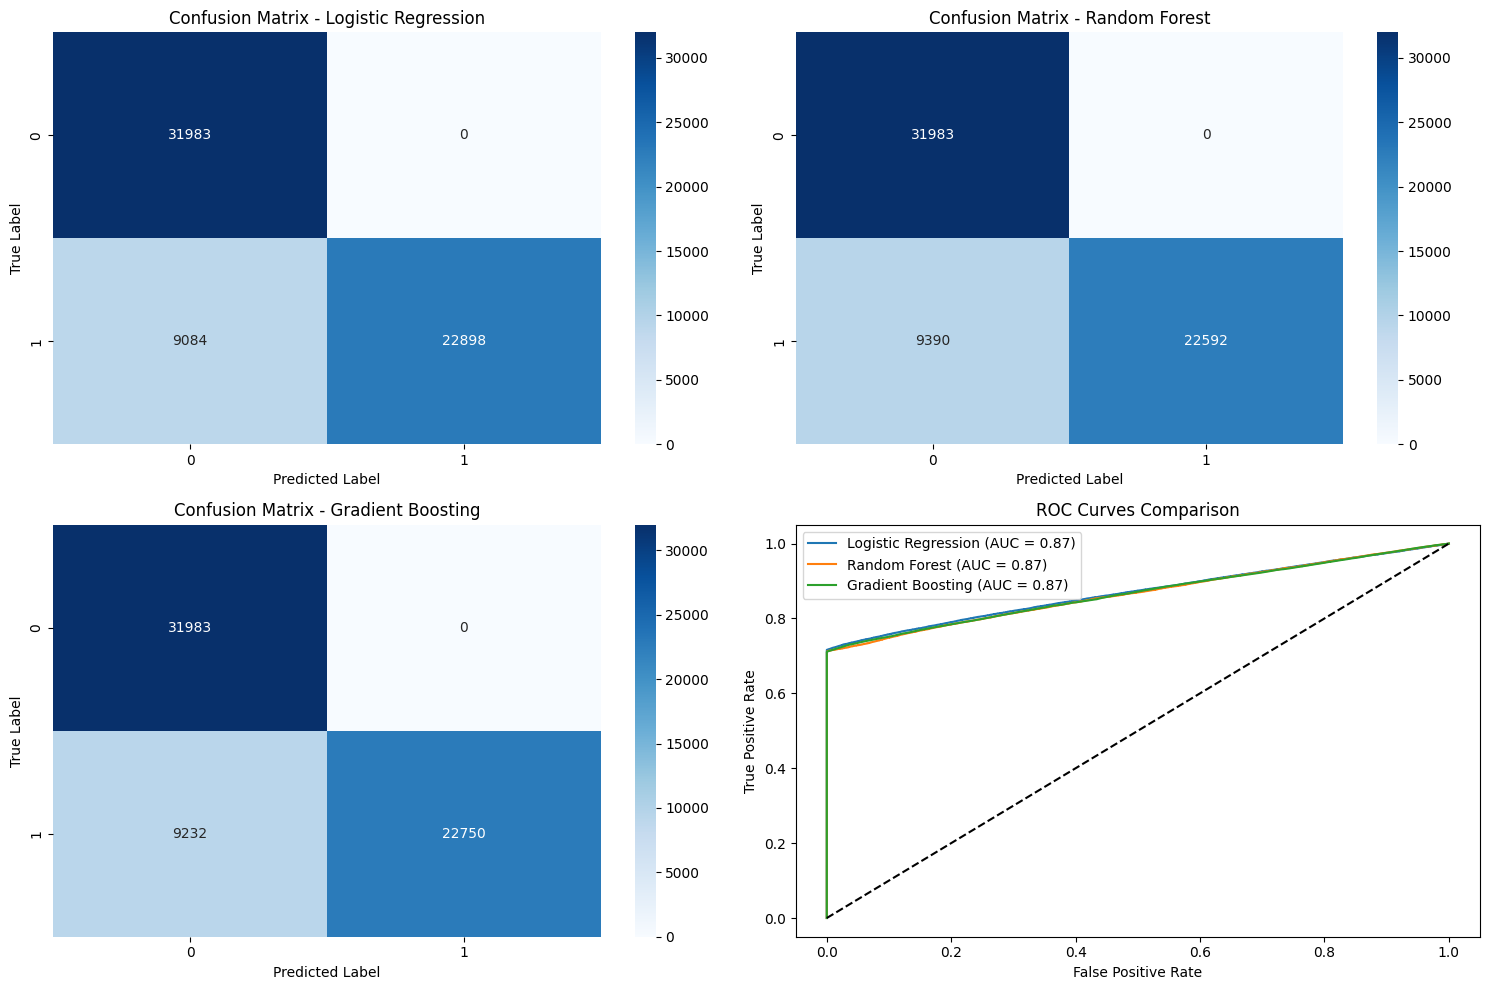

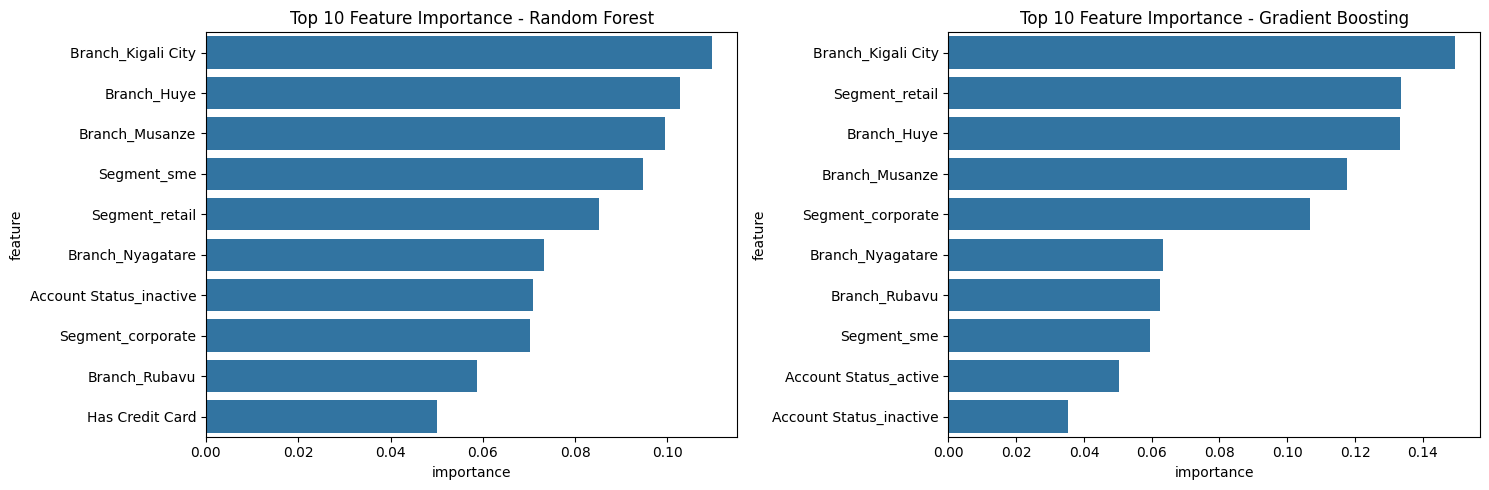


4. Best Model Selection:
Best model based on ROC-AUC: Logistic Regression (AUC = 0.87)

5. Model Saving Confirmation:
Best model saved as 'best_churn_model.pkl'


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

# Load and preprocess dataset
try:
    df = pd.read_csv('/content/CHURN-PREDICTION.csv')
    df.columns = df.columns.str.strip()
    print("Dataset loaded successfully (as of 12:33 PM CAT, 10/24/2025).")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Convert currency columns to numeric
for col in ['Balance', 'Average Transaction Value']:
    df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')
df = df.dropna()

# Drop non-predictive columns
df = df.drop(['Customer ID', 'Last Transaction Date', 'Account Open Date'], axis=1)

# Prepare features and target
X = pd.get_dummies(df.drop('Churn Label', axis=1))
y = df['Churn Label']

# Class distribution before and after SMOTE
print("\n1. Data Overview:")
print(f"Dataset shape (rows × columns): {df.shape}")
print("Class distribution (before balancing):")
print(y.value_counts())

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
print("Class distribution (after balancing):")
print(pd.Series(y).value_counts())

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train/test split summary: {X_train.shape[0]} train, {X_test.shape[0]} test")

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['Age', 'Balance', 'Tenure Months', 'Num of Products', 'Transaction Frequency',
                  'Average Transaction Value', 'Mobile Banking Usage', 'Branch Visits', 'Complaint History']
available_numerical_cols = [col for col in numerical_cols if col in X_train.columns]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[available_numerical_cols] = scaler.fit_transform(X_train[available_numerical_cols])
X_test_scaled[available_numerical_cols] = scaler.transform(X_test[available_numerical_cols])

# Initialize models
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, class_weight='balanced')
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

models = {'Logistic Regression': log_reg, 'Random Forest': rf_clf, 'Gradient Boosting': gb_clf}

# Train models and evaluate performance
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    }

# Print results in a table
print("\n2. Model Training & Evaluation:")
print("--------------------------------")
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1-score: {metrics['F1-score']:.2f}")
    print(f"ROC-AUC: {metrics['ROC-AUC']:.2f}")
    print("-------------------------------")

# Visualizations
plt.figure(figsize=(15, 10))

# Confusion Matrices
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# ROC Curves
plt.subplot(2, 2, 4)
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC-AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance for RF and GB
plt.figure(figsize=(15, 5))
for i, name in enumerate(['Random Forest', 'Gradient Boosting']):
    if name in models:
        plt.subplot(1, 2, i+1)
        importances = models[name].feature_importances_
        feature_names = X.columns
        feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_imp = feature_imp.sort_values('importance', ascending=False).head(10)
        sns.barplot(x='importance', y='feature', data=feature_imp)
        plt.title(f'Top 10 Feature Importance - {name}')
plt.tight_layout()
plt.show()

# Best Model Selection
best_model_name = max(models, key=lambda name: results[name]['ROC-AUC'])
print("\n4. Best Model Selection:")
print(f"Best model based on ROC-AUC: {best_model_name} (AUC = {results[best_model_name]['ROC-AUC']:.2f})")

# Save the best model
best_model = models[best_model_name]
joblib.dump(best_model, 'best_churn_model.pkl')
print("\n5. Model Saving Confirmation:")
print("Best model saved as 'best_churn_model.pkl'")